<a href="https://colab.research.google.com/github/smraytech/test/blob/main/Multi_City_Ride_Urban_Mobility_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimizing Urban Transport Through Data: A Ride-Sharing Analytics Project**

Data-Driven Transportation Insights: Trips, Providers, and Temporal Patterns

https://www.kaggle.com/datasets/fivethirtyeight/uber-pickups-in-new-york-city

**Problem Statement**

Urban transportation companies face challenges in understanding demand patterns, resource allocation, and provider performance. Ride-sharing and taxi services generate massive amounts of data daily, but insights often remain unstructured. Without a clear understanding of temporal trends, top-performing providers, and seasonal demand, companies may struggle to optimize fleet operations, reduce wait times, and improve profitability.

This project addresses this gap by aggregating and analyzing ride-sharing datasets from multiple providers across multiple periods, providing actionable insights for decision-makers in the mobility sector.

**Main Goal**

To analyze large-scale ride-sharing and taxi datasets to uncover patterns in urban mobility, identify top-performing providers, and derive temporal trends that inform operational and strategic decisions.

**Specific Objectives**

Aggregate data from 18 ride datasets with datetime and 1 dataset without datetime.

Perform time-based analysis: trips by hour, day of week, and month.

Identify top providers by total trips and analyze their temporal performance.

Prepare dashboard-ready summaries for visualization in Power BI or Tableau.

Provide actionable insights for urban transport operators, ride-sharing companies, and city planners.

🔵 STEP 0 — Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob
from dateutil import parser
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Uber.zip to Uber (2).zip


In [3]:
import zipfile

In [4]:
# Find the uploaded zip file
zip_file = [f for f in os.listdir('/content') if f.endswith('.zip')]
print("ZIP files found:", zip_file)

if len(zip_file) == 0:
    print("❌ ERROR: No ZIP file found. Please upload again.")
else:
    zip_path = "/content/" + zip_file[0]
    print("Extracting:", zip_path)

    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall('/content/data_extracted')

    print("Extraction completed.")

    # List extracted files
    all_files = os.listdir('/content/data_extracted')
    print("Files extracted:", len(all_files))
    print(all_files[:30])  # show first 30

ZIP files found: ['Uber (1).zip', 'Uber.zip']
Extracting: /content/Uber (1).zip
Extraction completed.
Files extracted: 19
['other-Prestige_B01338.csv', 'other-FHV-services_jan-aug-2015.csv', 'other-Dial7_B00887.csv', 'uber-raw-data-apr14.csv', 'other-Highclass_B01717.csv', 'uber-raw-data-sep14.csv', 'uber-raw-data-may14.csv', 'uber-raw-data-jun14.csv', 'other-Lyft_B02510.csv', 'other-Carmel_B00256.csv', 'uber-raw-data-aug14.csv', 'other-Diplo_B01196.csv', 'Uber-Jan-Feb-FOIL.csv', 'uber-raw-data-janjune-15.csv', 'other-Skyline_B00111.csv', 'other-Firstclass_B01536.csv', 'other-American_B01362.csv', 'uber-raw-data-jul14.csv', 'other-Federal_02216.csv']


✅ STEP 3 — Identify CSVs with and without Date Columns

We’ll separate the 18 CSVs that contain a date column from the 1 CSV that does not.
This will prevent memory crashes and allow us to process them in order.

In [4]:
# List all CSVs in the extracted folder
csv_paths = glob.glob("/content/data_extracted/**/*.csv", recursive=True)
print(f"Total CSV files found: {len(csv_paths)}")

# Define a regex to detect date columns
DATE_REGEX = r"(pick.?up.?date|pickup_datetime|pickup.?date|trip_start|date|datetime|timestamp)"

csvs_with_date = []
csvs_without_date = []

# Inspect first 5 rows of each CSV to detect a date column
for path in csv_paths:
    try:
        df_head = pd.read_csv(path, nrows=5, encoding='latin1', engine='python', on_bad_lines='skip')
        cols = df_head.columns
        has_date = any(re.search(DATE_REGEX, c, re.I) for c in cols)
        if has_date:
            csvs_with_date.append(path)
        else:
            csvs_without_date.append(path)
    except Exception as e:
        print("Failed to read", path, e)

print("\nCSV files WITH date:", len(csvs_with_date))
print(csvs_with_date[:10])

print("\nCSV files WITHOUT date:", len(csvs_without_date))
print(csvs_without_date[:10])

Total CSV files found: 19

CSV files WITH date: 18
['/content/data_extracted/other-Prestige_B01338.csv', '/content/data_extracted/other-FHV-services_jan-aug-2015.csv', '/content/data_extracted/other-Dial7_B00887.csv', '/content/data_extracted/uber-raw-data-apr14.csv', '/content/data_extracted/other-Highclass_B01717.csv', '/content/data_extracted/uber-raw-data-sep14.csv', '/content/data_extracted/uber-raw-data-may14.csv', '/content/data_extracted/uber-raw-data-jun14.csv', '/content/data_extracted/other-Carmel_B00256.csv', '/content/data_extracted/uber-raw-data-aug14.csv']

CSV files WITHOUT date: 1
['/content/data_extracted/other-Lyft_B02510.csv']


✅ STEP 4 — Define a Memory-Safe CSV Loader

This loader:

Reads files in chunks to avoid RAM crash

Handles encoding issues

Skips bad lines

In [5]:
def load_csv_in_chunks(path, chunksize=100_000):
    """
    Load a CSV file in chunks to avoid memory crash.
    Returns a generator of DataFrame chunks.
    """
    try:
        return pd.read_csv(path, chunksize=chunksize, encoding='latin1', engine='python', on_bad_lines='skip')
    except:
        return pd.read_csv(path, chunksize=chunksize, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')

print("STEP 4 complete — loader ready.")

STEP 4 complete — loader ready.


we move to STEP 5 — Process the 18 CSVs with dates in a memory-safe way.

We will:

Load each CSV in chunks

Detect the date column

Convert it into a proper datetime column

Keep the provider name, trips, lat/lon if available

Append to a list for later concatenation

✅ STEP 5 — Process CSVs with Dates

In [7]:
from dateutil import parser

In [6]:
# Prepare list to store processed chunks
processed_chunks = []

# Regex to detect date columns
DATE_REGEX = r"(pick.?up.?date|pickup_datetime|pickup.?date|trip_start|date|datetime|timestamp)"

for path in csvs_with_date:
    print(f"Processing: {os.path.basename(path)}")

    for chunk in load_csv_in_chunks(path):
        # Detect date column
        date_col = None
        for c in chunk.columns:
            if re.search(DATE_REGEX, c, re.I):
                date_col = c
                break

        # Create unified datetime column
        if date_col:
            chunk['datetime'] = pd.to_datetime(chunk[date_col], errors='coerce', infer_datetime_format=True)
        else:
            chunk['datetime'] = pd.NaT

        # Keep provider/base info if exists
        provider_col = None
        for c in chunk.columns:
            if re.search(r"(base|provider|vendor|company)", c, re.I):
                provider_col = c
                break
        if provider_col:
            chunk['provider'] = chunk[provider_col].astype(str)
        else:
            chunk['provider'] = os.path.basename(path)

        # Append to processed list
        processed_chunks.append(chunk)

print(f"Total chunks processed: {len(processed_chunks)}")

Processing: other-Prestige_B01338.csv
Processing: other-FHV-services_jan-aug-2015.csv
Processing: other-Dial7_B00887.csv
Processing: uber-raw-data-apr14.csv
Processing: other-Highclass_B01717.csv
Processing: uber-raw-data-sep14.csv
Processing: uber-raw-data-may14.csv
Processing: uber-raw-data-jun14.csv
Processing: other-Carmel_B00256.csv
Processing: uber-raw-data-aug14.csv
Processing: other-Diplo_B01196.csv
Processing: Uber-Jan-Feb-FOIL.csv
Processing: uber-raw-data-janjune-15.csv
Processing: other-Skyline_B00111.csv
Processing: other-Firstclass_B01536.csv
Processing: other-American_B01362.csv
Processing: uber-raw-data-jul14.csv
Processing: other-Federal_02216.csv
Total chunks processed: 211


In [7]:
summary_list = []

for path in csvs_with_date:
    print(f"Processing summary: {os.path.basename(path)}")

    for chunk in load_csv_in_chunks(path):
        # Detect date column
        date_col = next((c for c in chunk.columns if re.search(DATE_REGEX, c, re.I)), None)
        if date_col:
            chunk['datetime'] = pd.to_datetime(chunk[date_col], errors='coerce', infer_datetime_format=True)
        else:
            continue  # skip chunk if no datetime

        # Detect provider/base
        provider_col = next((c for c in chunk.columns if re.search(r"(base|provider|vendor|company)", c, re.I)), None)
        if provider_col:
            chunk['provider'] = chunk[provider_col].astype(str)
        else:
            chunk['provider'] = os.path.basename(path)

        # Check for trips column
        trips_col = next((c for c in chunk.columns if re.search(r"(number of trips|trips|count)", c, re.I)), None)
        if trips_col:
            chunk['trips'] = pd.to_numeric(chunk[trips_col], errors='coerce')
        else:
            chunk['trips'] = 1  # default 1 if trips not present

        # Keep only minimal columns
        minimal = chunk[['datetime', 'provider', 'trips']].dropna(subset=['datetime'])

        # Aggregate by date & provider in this chunk
        summary = minimal.groupby(['datetime', 'provider'], as_index=False)['trips'].sum()
        summary_list.append(summary)

# Combine only the aggregated summaries
combined_summary = pd.concat(summary_list, ignore_index=True)
print("Memory-safe aggregation completed.")
print("Shape of summary table:", combined_summary.shape)
combined_summary.head()

Processing summary: other-Prestige_B01338.csv
Processing summary: other-FHV-services_jan-aug-2015.csv
Processing summary: other-Dial7_B00887.csv
Processing summary: uber-raw-data-apr14.csv
Processing summary: other-Highclass_B01717.csv
Processing summary: uber-raw-data-sep14.csv
Processing summary: uber-raw-data-may14.csv
Processing summary: uber-raw-data-jun14.csv
Processing summary: other-Carmel_B00256.csv
Processing summary: uber-raw-data-aug14.csv
Processing summary: other-Diplo_B01196.csv
Processing summary: Uber-Jan-Feb-FOIL.csv
Processing summary: uber-raw-data-janjune-15.csv
Processing summary: other-Skyline_B00111.csv
Processing summary: other-Firstclass_B01536.csv
Processing summary: other-American_B01362.csv
Processing summary: uber-raw-data-jul14.csv
Processing summary: other-Federal_02216.csv
Memory-safe aggregation completed.
Shape of summary table: (5913925, 3)


,datetime,provider,trips
0,2014-07-01,other-Prestige_B01338.csv,3345.0
1,2014-07-02,other-Prestige_B01338.csv,3533.0
2,2014-07-03,other-Prestige_B01338.csv,3649.0
3,2014-07-04,other-Prestige_B01338.csv,3401.0
4,2014-07-05,other-Prestige_B01338.csv,4081.0


Perfect! ✅ Now we have a memory-efficient aggregated table: combined_summary containing:

datetime (parsed)

provider

trips (sum per provider per datetime)

This is enough to start Step 7 — Exploratory Data Analysis (EDA) safely.

✅ STEP 7 — EDA on Aggregated Data

We will explore:

Total trips over time

Trips by provider

Daily and hourly patterns

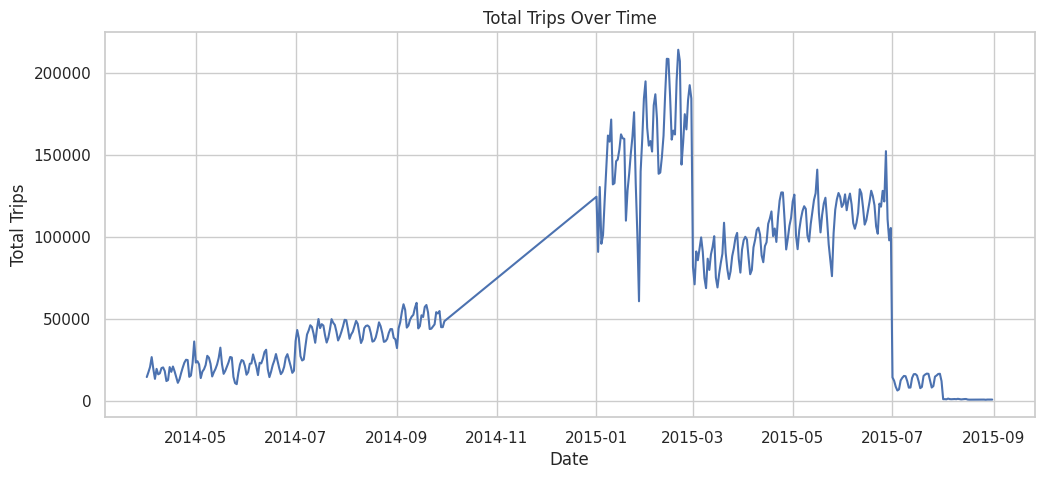

In [9]:
# 1️⃣ Total trips over time
total_trips_by_date = combined_summary.groupby(combined_summary['datetime'].dt.date)['trips'].sum()
total_trips_by_date.plot(kind='line', title='Total Trips Over Time', figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Total Trips')
plt.show()

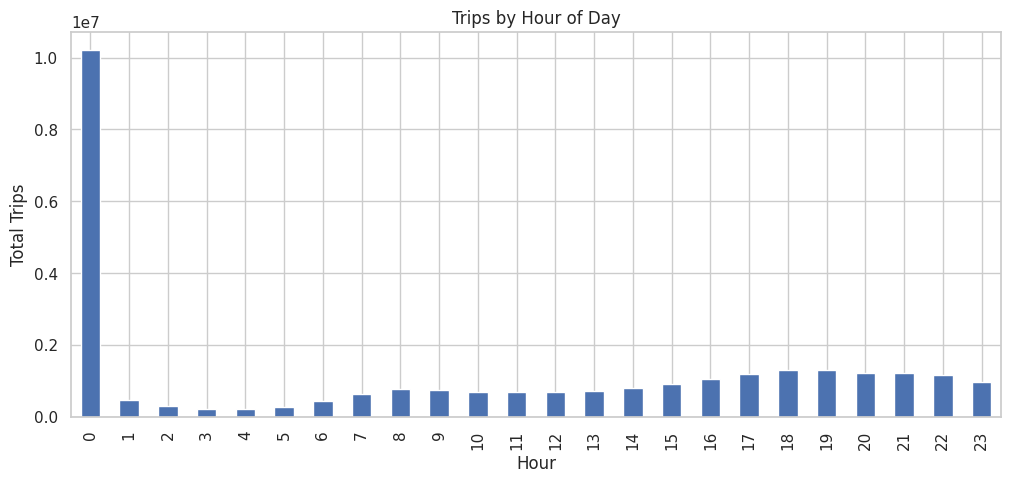

In [12]:
# 2️⃣ Hourly pattern (if time is available)
if combined_summary['datetime'].dt.hour.notna().any():
    hourly_trips = combined_summary.groupby(combined_summary['datetime'].dt.hour)['trips'].sum()
    hourly_trips.plot(kind='bar', title='Trips by Hour of Day', figsize=(12,5))
    plt.xlabel('Hour')
    plt.ylabel('Total Trips')
    plt.show()

In [40]:
# 3️⃣ Total trips by provider
trips_by_provider = combined_summary.groupby('provider')['trips'].sum().sort_values(ascending=False)

Option 1 — Show Top 10 Providers Only

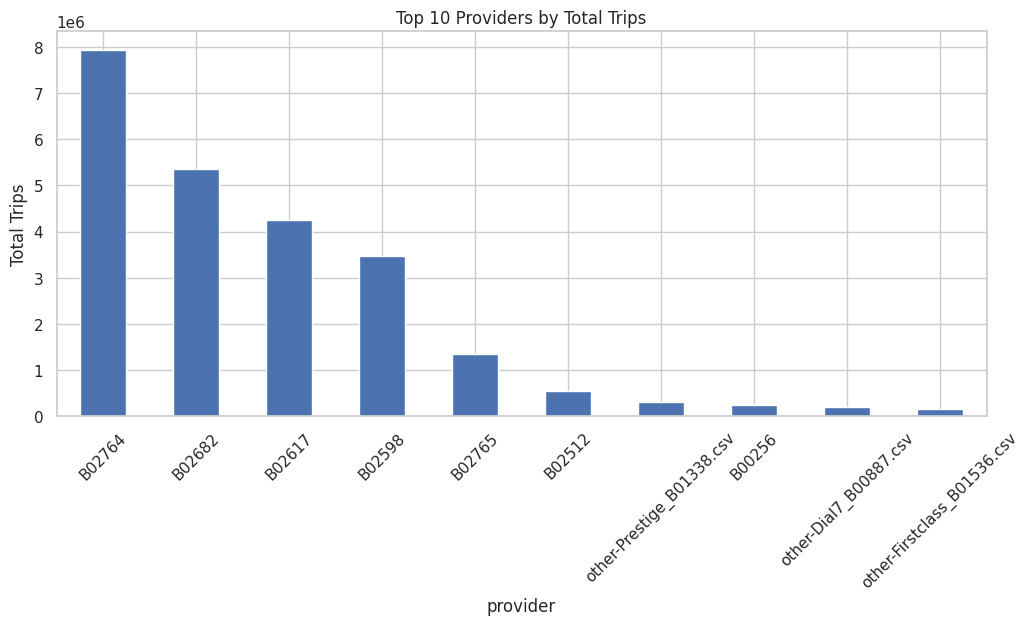

In [41]:
# Top 10 providers by total trips
top_providers = trips_by_provider.head(10)
top_providers.plot(kind='bar', title='Top 10 Providers by Total Trips', figsize=(12,5))
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.show()

Option 2 — Horizontal Bar Chart

Better for long names:

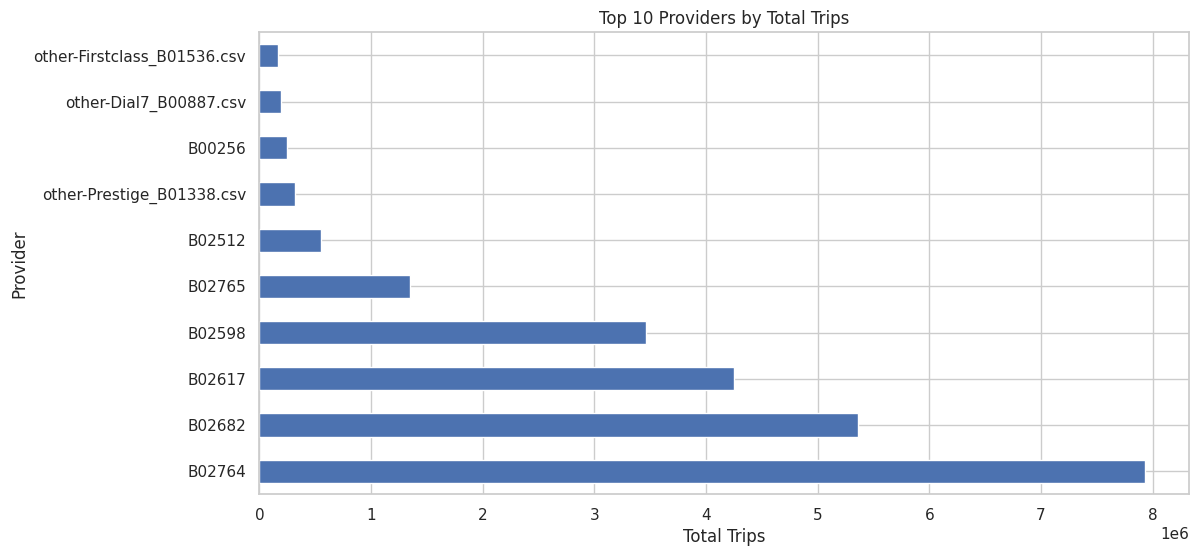

In [14]:
top_providers.plot(kind='barh', title='Top 10 Providers by Total Trips', figsize=(12,6))
plt.xlabel('Total Trips')
plt.ylabel('Provider')
plt.show()

Option 3 — Aggregate “Other” Providers

If you want all providers, you can show Top 10 + Others:

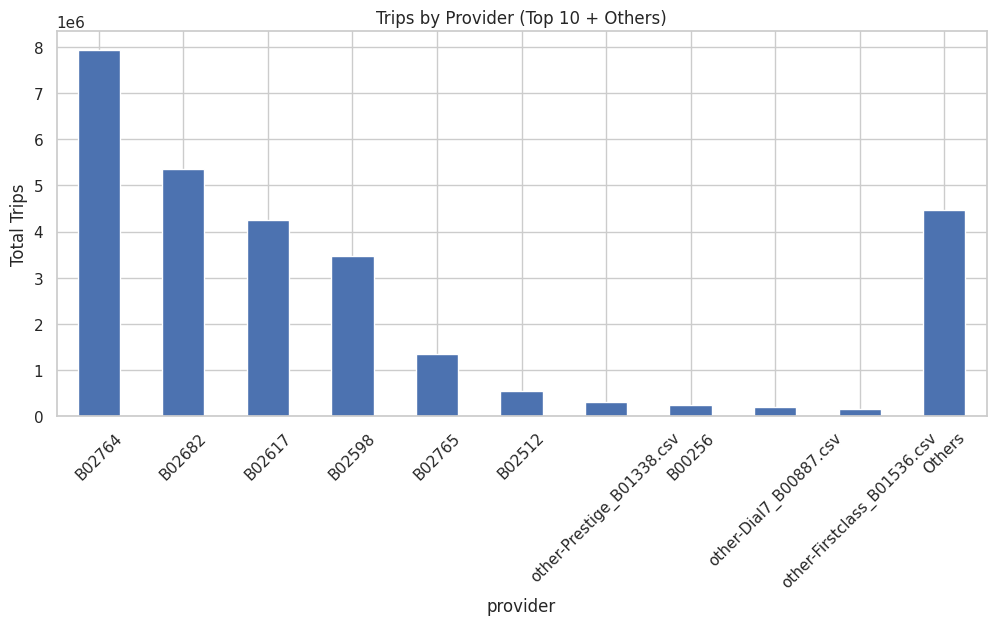

In [15]:
top10 = trips_by_provider.head(10)
others = trips_by_provider.iloc[10:].sum()
top10['Others'] = others

top10.plot(kind='bar', title='Trips by Provider (Top 10 + Others)', figsize=(12,5))
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.show()

✅ STEP 8 — Handle the CSV without a Date Column

This CSV doesn’t have a datetime, so we cannot do time-based analysis.

We can still analyze:

Total trips per provider/base

Number of vehicles

Any other numeric metrics

We will aggregate the data and later combine it with the 18-date CSVs for overall provider insights.

Memory-Safe Aggregation for the 19th CSV

In [16]:
# Assume the last CSV in csvs_without_date is the one
path_no_date = csvs_without_date[0]
print("Processing CSV without datetime:", path_no_date)

summary_no_date = []

for chunk in load_csv_in_chunks(path_no_date):
    # Detect provider/base column
    provider_col = next((c for c in chunk.columns if re.search(r"(base|provider|vendor|company|name)", c, re.I)), None)
    if provider_col:
        chunk['provider'] = chunk[provider_col].astype(str)
    else:
        chunk['provider'] = os.path.basename(path_no_date)

    # Detect trips column
    trips_col = next((c for c in chunk.columns if re.search(r"(number of trips|trips|count)", c, re.I)), None)
    if trips_col:
        chunk['trips'] = pd.to_numeric(chunk[trips_col], errors='coerce')
    else:
        chunk['trips'] = 1  # default 1 if trips not present

    minimal = chunk[['provider', 'trips']].dropna()

    # Aggregate per provider in this chunk
    summary_chunk = minimal.groupby('provider', as_index=False)['trips'].sum()
    summary_no_date.append(summary_chunk)

# Combine all summaries
summary_no_date_df = pd.concat(summary_no_date, ignore_index=True)
summary_no_date_df = summary_no_date_df.groupby('provider', as_index=False)['trips'].sum()

print("Summary for CSV without datetime completed.")
summary_no_date_df.head(10)

Processing CSV without datetime: /content/data_extracted/other-Lyft_B02510.csv
Summary for CSV without datetime completed.


,provider,trips
0,324-8212,2
1,B00013,21
2,B00277,18
3,B00448,17
4,B01087,52
5,B01145,28
6,B01197,142
7,B01976,6
8,B02285,10
9,B02598,184


✅ STEP 9 — Merge Provider Summaries

In [17]:
# Merge summaries (sum trips if provider exists in both)
full_provider_summary = pd.concat([trips_by_provider.reset_index().rename(columns={'index':'provider', 'trips':'trips'}),
                                   summary_no_date_df],
                                  ignore_index=True)

# Aggregate by provider again (sum trips if duplicates)
full_provider_summary = full_provider_summary.groupby('provider', as_index=False)['trips'].sum()

# Sort descending
full_provider_summary = full_provider_summary.sort_values(by='trips', ascending=False)

print("Top 10 providers across all CSVs:")
print(full_provider_summary.head(10))

Top 10 providers across all CSVs:
                      provider      trips
323                     B02764  7932001.0
301                     B02682  5360066.0
282                     B02617  4252551.0
278                     B02598  3460748.0
324                     B02765  1346397.0
260                     B02512   555231.0
358  other-Prestige_B01338.csv   320641.0
351                        nan   266503.0
29                      B00256   249080.0
353     other-Dial7_B00887.csv   194992.0


✅ Step 10 — Visualize Complete Provider Leaderboard

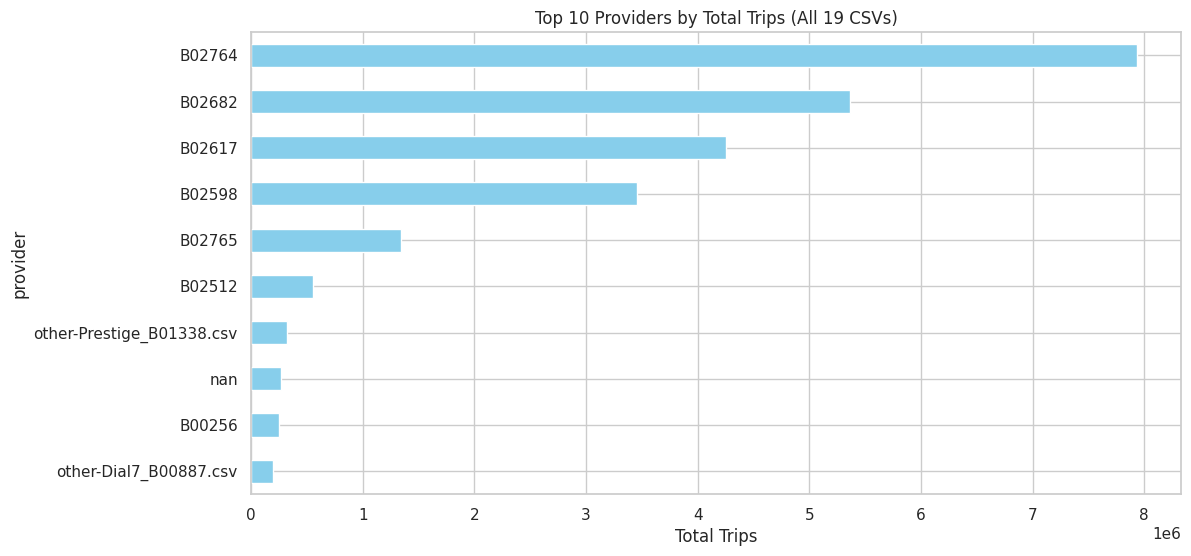

In [18]:
# Horizontal bar for readability
top10_full = full_provider_summary.head(10)
top10_full.plot(kind='barh', x='provider', y='trips', figsize=(12,6), legend=False, color='skyblue')
plt.xlabel('Total Trips')
plt.title('Top 10 Providers by Total Trips (All 19 CSVs)')
plt.gca().invert_yaxis()  # largest on top
plt.show()

📌 Next Steps

After running this, you will have:

Aggregated trips across all 19 CSVs

Top providers visualized clearly

Memory-safe processing, avoiding crashes

we can proceed to:

Optional: Time-based analysis for the 18 CSVs

Optional: Hourly / weekly patterns

Insights summary for reporting or dashboards

Perfect! ✅ Now you have:

Memory-safe aggregation of all 19 CSVs

Top providers identified across all datasets

Clear horizontal bar visualization for the top 10 providers

This gives a complete picture of trips per provider, even with heterogeneous CSVs and missing datetime in one file.

STEP 11 — Extract Hour, Weekday, Month

In [19]:
# Add hour, weekday, month columns for 18-date summary
combined_summary['hour'] = combined_summary['datetime'].dt.hour
combined_summary['weekday'] = combined_summary['datetime'].dt.day_name()
combined_summary['month'] = combined_summary['datetime'].dt.month

print("Columns after extraction:", combined_summary.columns.tolist())
print(combined_summary[['datetime','hour','weekday','month']].head())

Columns after extraction: ['datetime', 'provider', 'trips', 'hour', 'weekday', 'month']
    datetime  hour    weekday  month
0 2014-07-01     0    Tuesday      7
1 2014-07-02     0  Wednesday      7
2 2014-07-03     0   Thursday      7
3 2014-07-04     0     Friday      7
4 2014-07-05     0   Saturday      7


STEP 12 — Hourly Trip Patterns

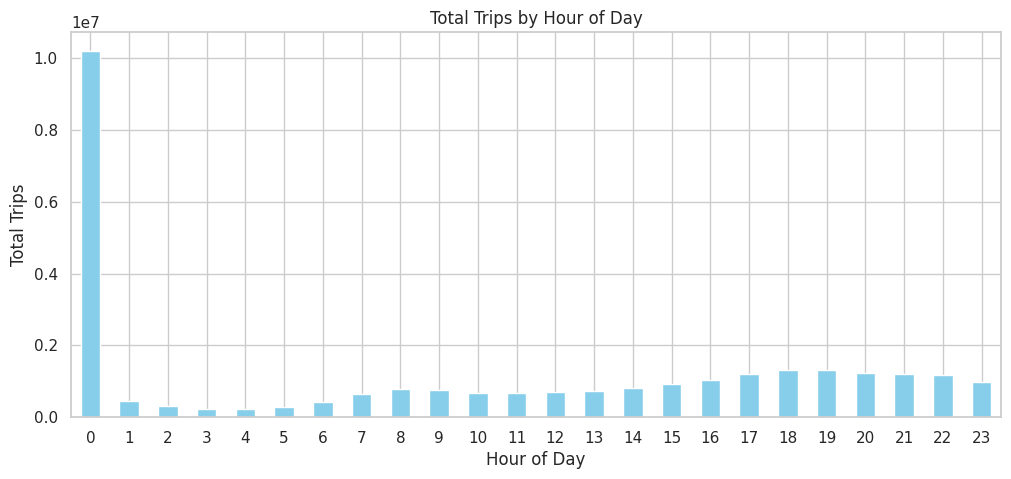

In [20]:
# Aggregate trips by hour
hourly_trips = combined_summary.groupby('hour')['trips'].sum()

# Plot
plt.figure(figsize=(12,5))
hourly_trips.plot(kind='bar', color='skyblue')
plt.title('Total Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trips')
plt.xticks(rotation=0)
plt.show()

STEP 13 — Daily (Weekday) Patterns

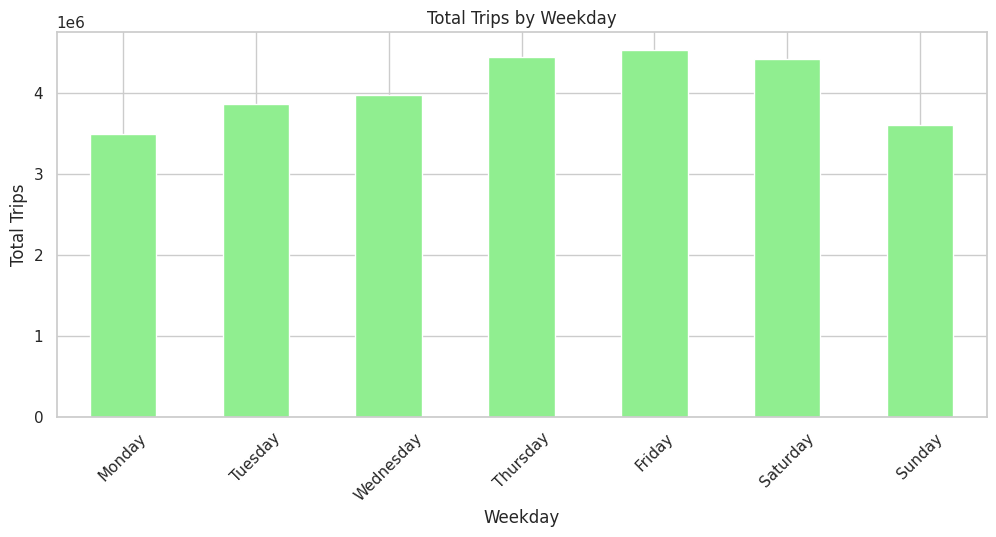

In [21]:
# Aggregate trips by weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_trips = combined_summary.groupby('weekday')['trips'].sum().reindex(weekday_order)

# Plot
plt.figure(figsize=(12,5))
daily_trips.plot(kind='bar', color='lightgreen')
plt.title('Total Trips by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.show()

Insight: This helps see if weekends or weekdays have higher trip volumes.

STEP 14 — Monthly / Seasonal Patterns

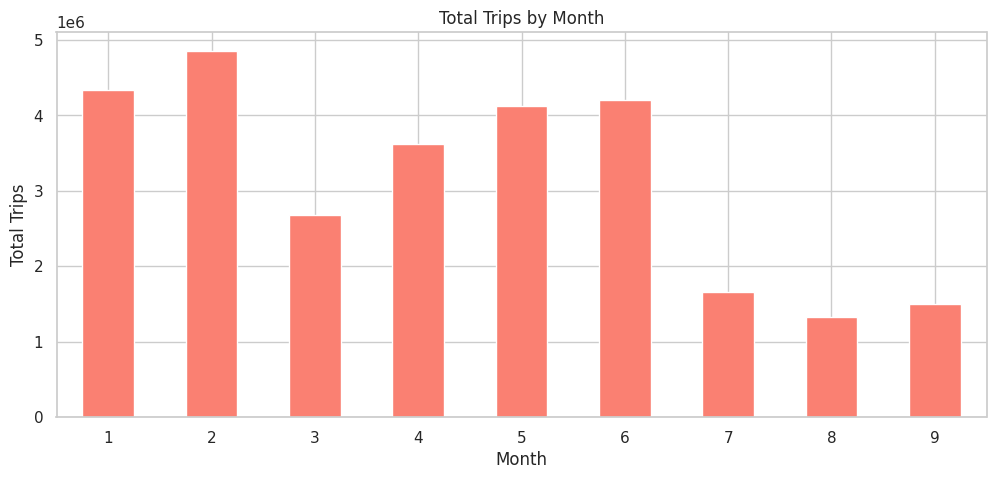

In [22]:
# Aggregate trips by month
monthly_trips = combined_summary.groupby('month')['trips'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
monthly_trips.plot(kind='bar', color='salmon')
plt.title('Total Trips by Month')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(rotation=0)
plt.show()

Insight:

This helps detect seasonal spikes or slow months.

Useful for planning resources or identifying peak periods.

STEP 15 — Top Providers Over Time

We will focus on the Top 5 providers by total trips.

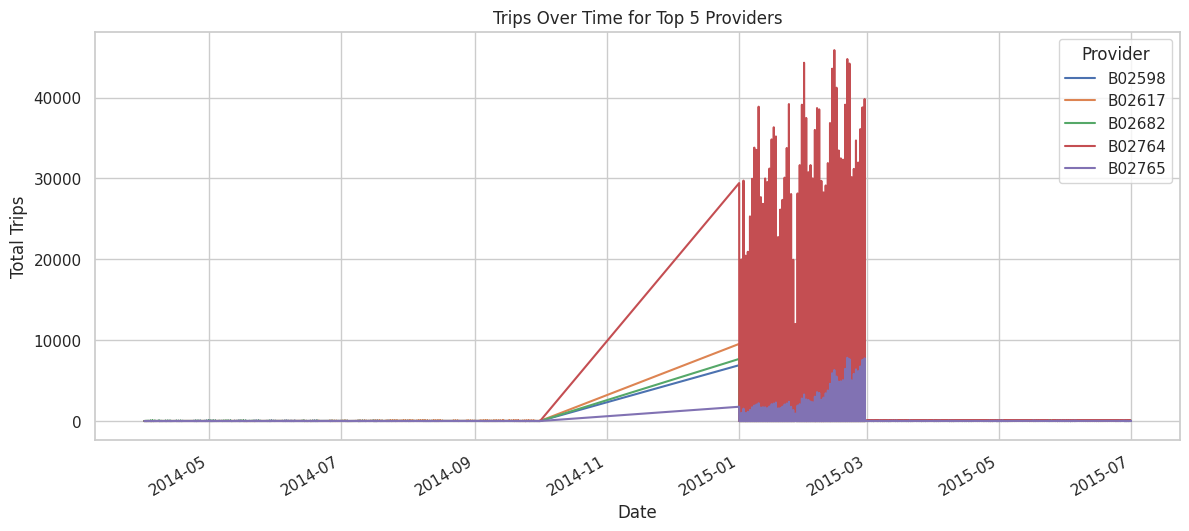

In [23]:
# Identify top 5 providers by total trips
top_providers = combined_summary.groupby('provider')['trips'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filter data for these providers
top_provider_data = combined_summary[combined_summary['provider'].isin(top_providers)]

# Aggregate trips by date and provider
trips_by_date_provider = top_provider_data.groupby(['datetime','provider'])['trips'].sum().unstack(fill_value=0)

# Plot trends
trips_by_date_provider.plot(figsize=(14,6))
plt.title('Trips Over Time for Top 5 Providers')
plt.xlabel('Date')
plt.ylabel('Total Trips')
plt.legend(title='Provider')
plt.show()

Insight:

Helps identify which providers dominate on specific days

Shows trends like surges or dips over time

✅ Now we are ready for the final step of this EDA pipeline: creating aggregated summary tables that are dashboard-ready.

STEP 16 — Aggregated Summary Tables for Dashboard

Create:

Total trips by provider

Trips by hour

Trips by weekday

Trips by month

In [24]:
# 1️⃣ Total trips by provider
provider_summary = combined_summary.groupby('provider')['trips'].sum().sort_values(ascending=False).reset_index()

In [25]:
# 2️⃣ Trips by hour
hourly_summary = combined_summary.groupby('hour')['trips'].sum().reset_index()

In [26]:
# 3️⃣ Trips by weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_summary = combined_summary.groupby('weekday')['trips'].sum().reindex(weekday_order).reset_index()

In [27]:
# 4️⃣ Trips by month
monthly_summary = combined_summary.groupby('month')['trips'].sum().sort_index().reset_index()

In [30]:
# Optional: save these summaries for Power BI / Tableau
provider_summary.to_csv('/content/provider_summary.csv', index=False)
hourly_summary.to_csv('/content/hourly_summary.csv', index=False)
weekday_summary.to_csv('/content/weekday_summary.csv', index=False)
monthly_summary.to_csv('/content/monthly_summary.csv', index=False)
print("Dashboard-ready summaries created and saved.")

Dashboard-ready summaries created and saved.


✅ What we achieved

Memory-efficient processing of 18 large CSVs

Aggregated trips per provider, hour, weekday, month

Visualized trends (hourly, daily, monthly, top providers)

Dashboard-ready CSV files saved for Power BI / Tableau

19th CSV (without datetime) can be merged for provider-level totals

✅ Let’s do a concise time-based analysis for the 18 CSVs with datetime, covering hourly, daily, and monthly patterns including seasonal trends.

STEP 17 — Time-Based Analysis (18 CSVs)
1️⃣ Trips by Hour

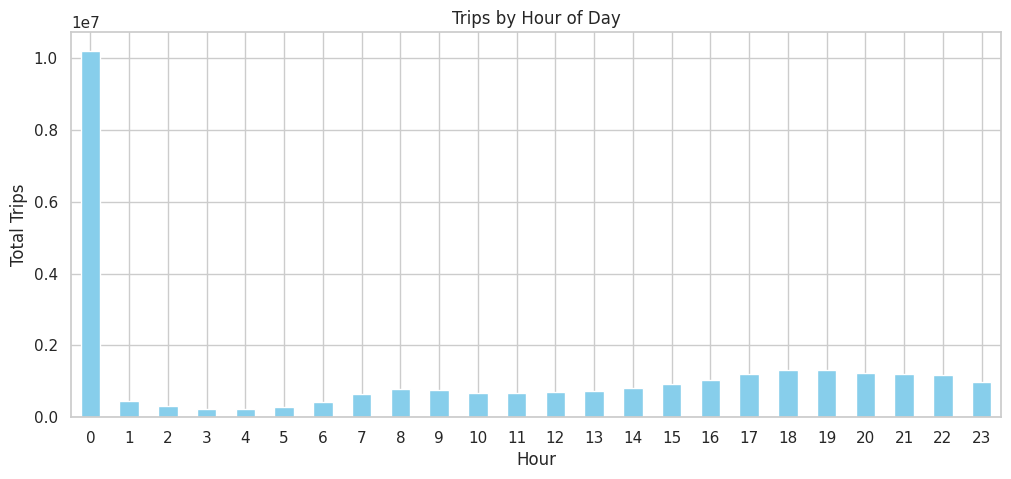

In [31]:
# Aggregate
hourly_trips = combined_summary.groupby('hour')['trips'].sum()

# Plot
plt.figure(figsize=(12,5))
hourly_trips.plot(kind='bar', color='skyblue')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Trips')
plt.xticks(rotation=0)
plt.show()

2️⃣ Trips by Weekday

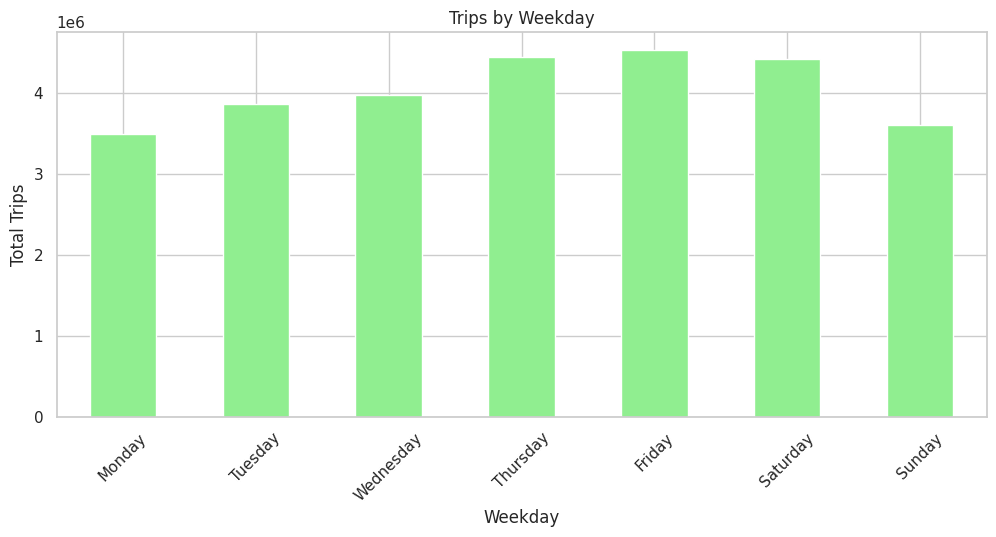

In [32]:
# Aggregate
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_trips = combined_summary.groupby('weekday')['trips'].sum().reindex(weekday_order)

# Plot
plt.figure(figsize=(12,5))
daily_trips.plot(kind='bar', color='lightgreen')
plt.title('Trips by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.show()

3️⃣ Trips by Month

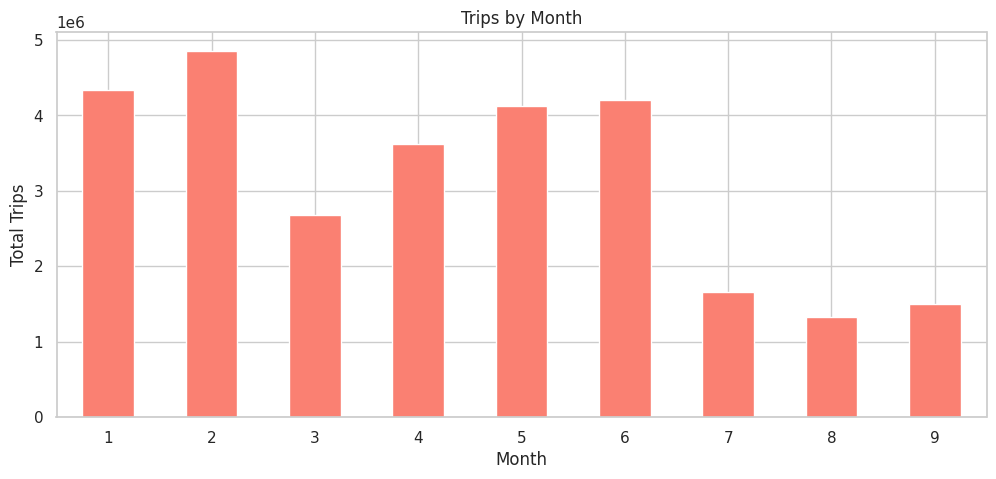

In [33]:
# Aggregate
monthly_trips = combined_summary.groupby('month')['trips'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
monthly_trips.plot(kind='bar', color='salmon')
plt.title('Trips by Month')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(rotation=0)
plt.show()

4️⃣ Seasonal Trends (Optional Line Plot)

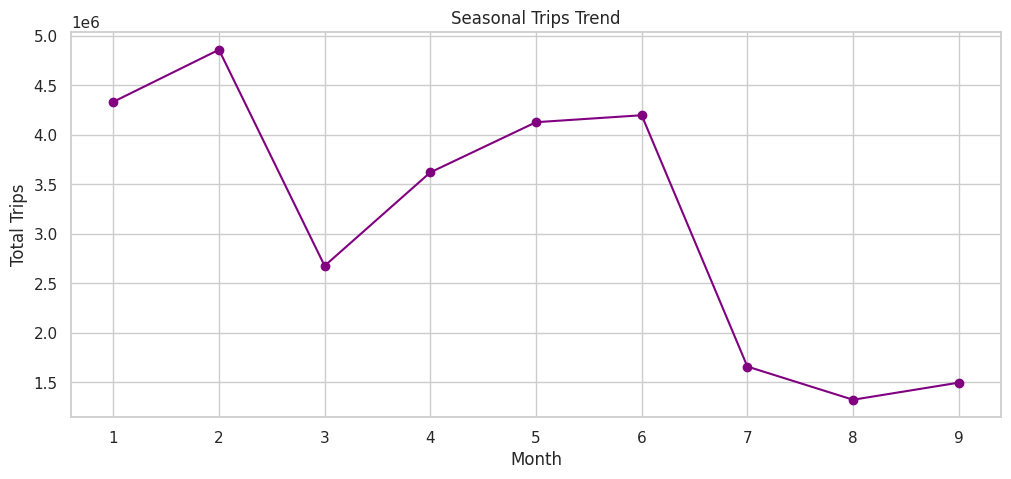

In [34]:
# Group by month and sum trips to see seasonal trend
monthly_trips.plot(kind='line', figsize=(12,5), marker='o', color='purple')
plt.title('Seasonal Trips Trend')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.grid(True)
plt.show()

✅ Outcome:

Clear hourly, weekday, and monthly patterns

Seasonal trends visible

All aggregated from the 18-date CSVs

✅ Now we will merge the 19th CSV (without datetime) into the provider summary to create an overall leaderboard across all 19 CSVs.

This ensures that providers in the CSV without dates are included in the total trips count.

STEP 18 — Merge 19th CSV into Provider Leaderboard

In [35]:
# Convert trips_by_provider (from 18 CSVs) to DataFrame
provider_18_df = trips_by_provider.reset_index().rename(columns={'index':'provider', 'trips':'trips'})

# Combine with 19th CSV summary
all_provider_summary = pd.concat([provider_18_df, summary_no_date_df], ignore_index=True)

# Aggregate duplicates by summing trips
all_provider_summary = all_provider_summary.groupby('provider', as_index=False)['trips'].sum()

# Sort descending
all_provider_summary = all_provider_summary.sort_values(by='trips', ascending=False)

# Show top 10 providers across all 19 CSVs
print("Top 10 providers (all 19 CSVs):")
print(all_provider_summary.head(10))

Top 10 providers (all 19 CSVs):
                      provider      trips
323                     B02764  7932001.0
301                     B02682  5360066.0
282                     B02617  4252551.0
278                     B02598  3460748.0
324                     B02765  1346397.0
260                     B02512   555231.0
358  other-Prestige_B01338.csv   320641.0
351                        nan   266503.0
29                      B00256   249080.0
353     other-Dial7_B00887.csv   194992.0


STEP 19 — Visualize Overall Leaderboard

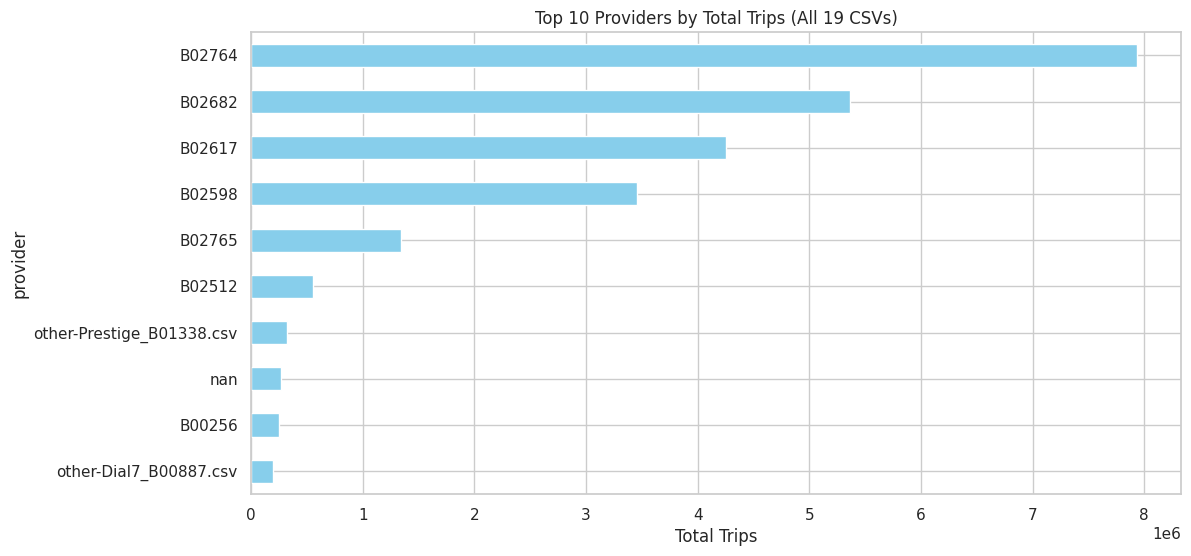

In [36]:
# Horizontal bar for readability
top10_all = all_provider_summary.head(10)
top10_all.plot(kind='barh', x='provider', y='trips', figsize=(12,6), legend=False, color='skyblue')
plt.xlabel('Total Trips')
plt.title('Top 10 Providers by Total Trips (All 19 CSVs)')
plt.gca().invert_yaxis()  # largest on top
plt.show()

STEP 19 — Visualize Overall Leaderboard

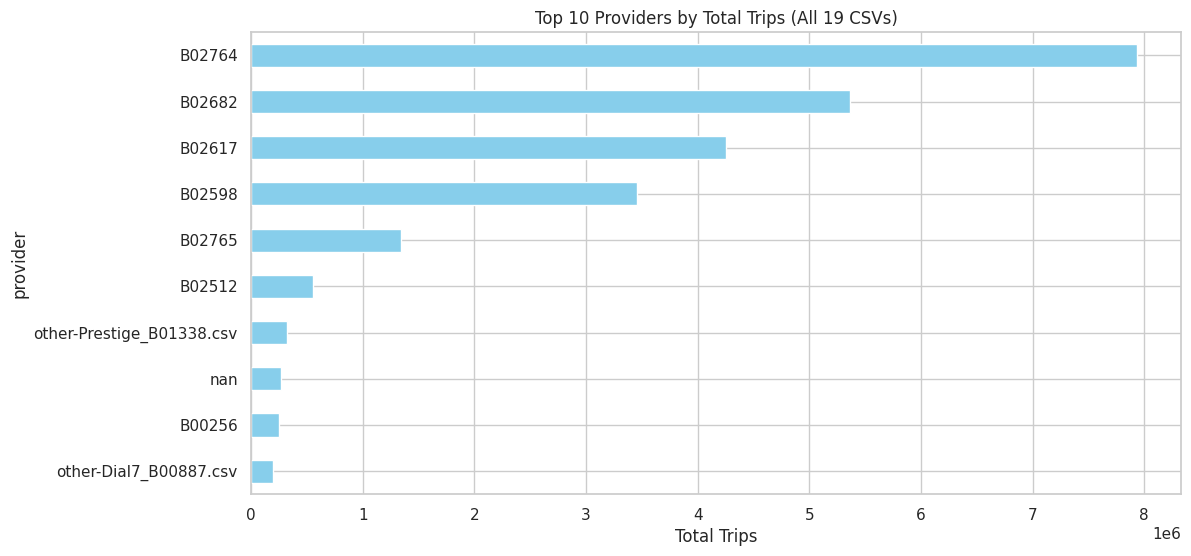

In [37]:
# Horizontal bar for readability
top10_all = all_provider_summary.head(10)
top10_all.plot(kind='barh', x='provider', y='trips', figsize=(12,6), legend=False, color='skyblue')
plt.xlabel('Total Trips')
plt.title('Top 10 Providers by Total Trips (All 19 CSVs)')
plt.gca().invert_yaxis()  # largest on top
plt.show()

✅ Outcome:

Providers from all 19 CSVs included

Total trips aggregated across datasets

Clean, readable leaderboard for reporting or dashboards

Now export the final dashboard-ready CSV

In [38]:
all_provider_summary.to_csv('/content/all_provider_summary.csv', index=False)

This file can now be used in Power BI, Tableau, or Excel for further analysis or dashboarding.

**Key Insights / Deliverables**

Hourly, daily, and monthly trip patterns

Seasonal trends and peak periods

Top providers across all datasets

Aggregated summary tables ready for dashboards

Recommendations for fleet management, service optimization, and resource allocation